# Setup and install for SVHN

In [ ]:
%pip install gpflow
%pip install plotnine

In [ ]:
import tensorflow as tf
from scipy.io import loadmat
import random
import math
import tensorflow_probability as tfp

_paper_name_ establishes the reusable name of the paper, it represents the directory under data_papers on the google drive

In [ ]:
paper_name = "gpSVHN"

In [ ]:
import os, sys
import errno

# make a directory if it does not exist
def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')

# make directories if they do not exist

make_dir_if_not_exist("/content/drive/MyDrive/data_papers/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_predictions/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/")


This will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

[Here](https://github.com/aditya9211/SVHN-CNN/blob/master/svhn_model.ipynb) is a github project that uses the same data.



In [ ]:
data_location = '/content/drive/MyDrive/mlpapers/GP_Collab_SVHN'

In [ ]:
# Run this cell to load the dataset
train = loadmat(f'{data_location}/train_32x32.mat')
test = loadmat(f'{data_location}/test_32x32.mat')
extra = loadmat(f'{data_location}/extra_32x32.mat')

In [ ]:
# we have  png files with house numbers for the extra as well, in case of other ideas
# https://stackoverflow.com/questions/15612373/convert-image-png-to-matrix-and-then-to-1d-array

In [ ]:
# Set up the imports
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Concatenate, Add, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np

import site
import os
import tensorflow as tf
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import errno
import numpy as np
import itertools
import multiprocessing
import json
import datetime
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import  Dense, Flatten, Activation, Dropout, Embedding, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Concatenate, BatchNormalization, GaussianNoise, AveragePooling2D
from tensorflow.keras.layers import LSTM, TimeDistributed, Permute, Reshape, Lambda, RepeatVector, Input, Multiply, SimpleRNN, GRU, LeakyReLU, Add
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.summary import create_file_writer

pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 40)


## Inspect and Preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* turn test into validation and slice some extra for test
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel.
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.
# Why greyscale?
* So we get worse performance and have less discriminating features, allowing us to discern the impact of the GP on the features in _collaborative_ learning better.


In [ ]:
train_data = train['X']
validation_data = test['X']
test_data = extra['X'][:,:,:,:30000]
train_targets = train['y']
validation_targets = test['y']
test_targets = extra['y'][:30000]

In [ ]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        title = "Label: {0}".format(true_number)
            
        ax.imshow(images[:,:,:,i])
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

def plot_sample(num_sample=10):
    idxs = sorted(random.sample(range(train_targets.shape[0]),num_sample))
    plot_images(train_data[:,:,:,idxs],2,math.ceil(num_sample/2),train_targets[idxs])    
    print(idxs)


[9308, 17861, 24698, 28938, 33854, 36911, 41735, 49577, 63105, 69802]


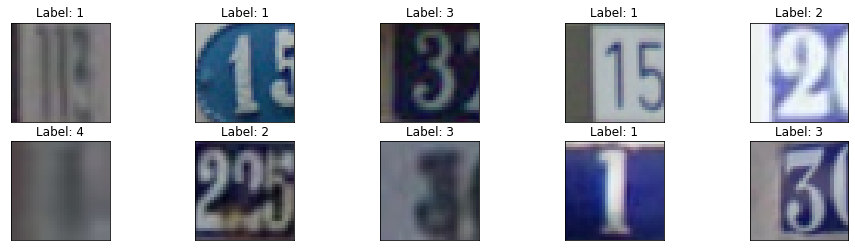

In [ ]:
plot_sample(10)

Convert the train, test and validation data to greyscale

In [ ]:
train_data_grey = train_data.mean(axis=2)
train_data_grey = np.expand_dims(train_data_grey,axis=2)
train_data_grey = np.moveaxis(train_data_grey, 3, 0)

test_data_grey = test_data.mean(axis=2)
test_data_grey = np.expand_dims(test_data_grey,axis=2)
test_data_grey = np.moveaxis(test_data_grey, 3, 0)

validation_data_grey = validation_data.mean(axis=2)
validation_data_grey = np.expand_dims(validation_data_grey,axis=2)
validation_data_grey = np.moveaxis(validation_data_grey, 3, 0)

print(train_data.shape)
print(train_data_grey.shape)

(32, 32, 3, 73257)
(73257, 32, 32, 1)


Set the 10th class to zero (represents '0' digit)

In [ ]:
train_targets[train_targets == 10] = 0
validation_targets[validation_targets == 10] = 0
test_targets[test_targets == 10] = 0

In [ ]:
def plot_images_grey(images, nrows, ncols, cls_true):
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        title = "Label: {0}".format(true_number)
        ax.imshow(images[i,:,:,0],cmap='gray', vmin=0, vmax=255)
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

def plot_sample_grey(num_sample=10):
    idxs = sorted(random.sample(range(train_targets.shape[0]),num_sample))
    plot_images_grey(train_data_grey[idxs,:,:,:],2,math.ceil(num_sample/2),train_targets[idxs])    
    print(idxs)


[6537, 8528, 9926, 14410, 15608, 16284, 31531, 33842, 63575, 65020]


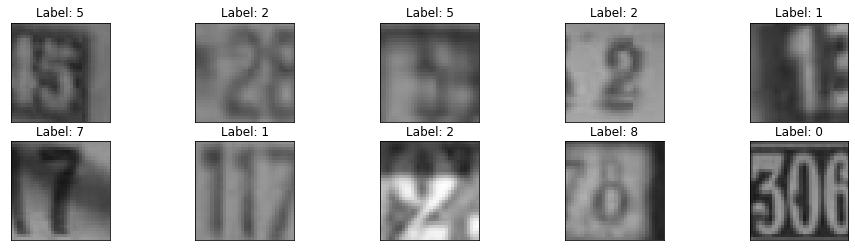

In [ ]:
plot_sample_grey(10)

In [ ]:
# extracts the layer from a model using the name
def get_layer_by_name(layers, name, return_first=True):
    matching_named_layers = [l for l in layers if l.name == name]
    if not matching_named_layers:
        return None
    return matching_named_layers[0] if return_first else matching_named_layers


In [ ]:
# plotting utilities for the history of the fit
def plot_history(history):
    acc_keys = [k for k in history.history.keys() if 'accuracy' in k]
    loss_keys = [k for k in history.history.keys() if not k in acc_keys]
    for k, v in history.history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        else:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()

def plot_history_df(history):
    acc_keys = [k for k in history.columns.values if 'accuracy' in k]
    loss_keys = [k for k in history.columns.values if not k in acc_keys and not k in ['epoch']]
    for k, v in history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        if k in loss_keys:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()   


A function that will take a model construction function (with _model_name_ and _input_shape_ arguments), train and fit it using the supplied data and callbacks. The _kwargs_ are supplied to the model fit function.

In [ ]:
from tensorflow.keras.callbacks import CSVLogger
import datetime

def compile_and_fit_model_basic(  model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_max_epoch=True,
                                  save_final=False,
                                  patience_count = None,
                                  early_stopping_obs = 'val_sparse_categorical_accuracy',
                                  log_history = True,
                                  verbose_level = 0,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
      
    if 'validation_data' not in kwargs.keys() and 'val_' in early_stopping_obs:
        early_stopping_obs = early_stopping_obs.replace('val_','')

    callbacks_used = []
    if save_max_epoch:
        callbacks_used.append(ModelCheckpoint(f'/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/{m.name}' + '_model_{epoch:03d}_{accuracy:0.3f}',
                                              save_weights_only=False,
                                              monitor = early_stopping_obs,
                                              mode='max',
                                              save_best_only=True))
    if patience_count is not None:
        callbacks_used.append(tf.keras.callbacks.EarlyStopping(monitor=early_stopping_obs, patience=patience_count))

    if log_history:
        callbacks_used.append(tf.keras.callbacks.CSVLogger(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/history_log_{model_name}_{datetime.date.today().strftime('%Y%m%d')}.csv", append=True))

    m.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    history = m.fit(X_train, Y_train, callbacks=callbacks_used, verbose=verbose_level, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)

A function that given a model or model directory create a new model up to the _layer_name_, then write the features matching the supplied _X_ and _Y_ as numpy arrays to google drive.

In [ ]:
def write_features_from_models(
        model_entry,
        layer_name,
        X_input, Y_input,
        reverse_one_hot=False,
        normalize_X_func=None,
        dataset_id = "NA",
        **kwargs):
  
    Y_new = None
    X_new = None
    if reverse_one_hot:
        Y_new = np.apply_along_axis(np.argmax, 1, Y_input) + 1
    else:
        Y_new = Y_input.copy()

    model_here = None
    if isinstance(model_entry, tf.keras.models.Model):
        model_here = model_entry
        model_file_name = model_here.name
    else:
        model_here = tf.keras.models.load_model(model_entry,**kwargs) 

    features_model = Model(model_here.input,
                            get_layer_by_name(model_here.layers, layer_name).output)
    if normalize_X_func is None:
        X_new = np.array(features_model.predict(X_input), dtype='float64')
    else:
        X_new = np.array(normalize_X_func(features_model.predict(X_input)), dtype='float64')

    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_X", X_new, 
               allow_pickle=True, 
               fix_imports=True)
    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_Y", Y_new, 
               allow_pickle=True, 
               fix_imports=True)

Some functions to get scores on the results

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import re

def get_confusion_matrix_classification(model, X, Y_true):
    y_pred = model.predict(X)
    y_true = np.apply_along_axis(np.argmax, 1, Y_true)
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def construct_confusion_matrix(X, Y_true, Y_pred):
    y_true = Y_true
    y_pred = np.apply_along_axis(np.argmax, 1, Y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def pr_rc_f1_acc_from_supplied(y_pred, y_true):  
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")   
    acc = accuracy_score(y_true, y_pred)
    return pr, rc, f1, acc


In [ ]:
import re
import os

def dir_has_file_with_regex(dir_name, regex_string):
  filenames = [ f"{dir_name}/{dir_entry.name}" for dir_entry in os.scandir(dir_name) if os.path.isfile(f"{dir_name}/{dir_entry.name}") ]   
  filenames = [ fn for fn in filenames if re.match(regex_string, fn, re.IGNORECASE) ]
  return filenames



In [ ]:
# dir_has_file_with_regex("/content/drive/MyDrive/data_papers/gpSVHN/model_features", "^.*DNN_A_.*D3R_Test_X.*")

# A basic DNN to fit SVHN

In [ ]:
def basic_DNNTemplate_A(model_name, inshape, num_classes = 10):
 
  base_input = Input(shape=inshape, name='base_input')
  f1_output = Flatten(name='F1')(base_input)
  d1_output = Dense(128, activation='relu', name = 'D1')(f1_output)
  d2_output = Dense(128, activation='relu', name = 'D2')(d1_output)
  d3r_output = Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005), name = 'D3R')(d2_output)
  model_output = Dense(10,  activation='softmax', name = 'SFTMX1')(d3r_output)
  model = Model(base_input, model_output, name = model_name)

  return model

In [ ]:
# # saving 100 DNNs
for model_count in [i+1 for i in range(100)]:
  m1, h1 = compile_and_fit_model_basic( basic_DNNTemplate_A,  
                    f"DNN_A_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    train_data_grey[0,:,:,:].shape, 
                    train_data_grey, train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(validation_data_grey, validation_targets))

# # /content/drive/MyDrive/data_papers/gpSVHN/model_finals/DNN_A_6_20210923210545_saved_model_after_fit/assets
# plot_history(h1)

In [ ]:
# saving the features of 100 DNNs for the train data

check_model_string = "DNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([(not ncs in dir_entry.name) for ncs in not_check_model_string]):
      # f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_X"
      # f"DNN_A_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}"
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_D3R_Train.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "D3R",
          train_data_grey, train_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Train")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Train.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "SFTMX1",
          train_data_grey, train_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Train")      

In [ ]:
# saving the features of 100 DNNs for the validation data
check_model_string = "DNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([(not ncs in dir_entry.name) for ncs in not_check_model_string]):
      # f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_X"
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_D3R_Validation.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "D3R",
          validation_data_grey, validation_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Validation")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Validation.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "SFTMX1",
          validation_data_grey, validation_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Validation")      

In [ ]:
# saving the features of 100 DNNs for the test data
check_model_string = "DNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([(not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name}.*_features_D3R_Test.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "D3R",
          test_data_grey, test_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Test")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name}.*_features_SFTMX1_Test.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "SFTMX1",
          test_data_grey, test_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Test")      

In [ ]:
# getting the scores for the individual 100 DNNs on the test data set
scores_dnn_simple = []
check_model_string = "DNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      print(dir_entry.name)
      model_here = tf.keras.models.load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}")  
      y_predict_here = np.array(model_here.predict(test_data_grey), dtype='float64')
      y_predict_here = np.apply_along_axis(np.argmax, 1, y_predict_here)
      scores_dnn_simple.append(pr_rc_f1_acc_from_supplied(y_predict_here, test_targets))

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_dnn_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_dnn_simple), 
               allow_pickle=True, 
               fix_imports=True)



# Save the validation results for all the DNN to see whether it can be used for 'selecting' models

In [ ]:
all_histories = os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history")

all_dnn_histories = [f for f in all_histories if "DNN_" in f and "arallel" not in f and "ollab" not in f]
# all_cnn_histories = [f for f in all_histories if "CNN_" in f and "arallel" not in f and "ollab" not in f]
# all_resnet50_histories = [f for f in all_histories if "RestNet50" in f and "arallel" not in f and "ollab" not in f]
# all_WideResNet_histories = [f for f in all_histories if "WideResNet" in f and "arallel" not in f and "ollab" not in f]


In [ ]:
import pandas as pd

def get_validation_acc_from_history_file(f1):
  pd1 = pd.read_csv(f1)
  return pd1[pd1.epoch==max(pd1.epoch)].val_sparse_categorical_accuracy.iloc[0]


In [ ]:
dnn_val_accs = pd.DataFrame( { "Type": "DNN", "File": all_dnn_histories, "ValAcc" : [ get_validation_acc_from_history_file(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/{f}") for f in all_dnn_histories  ] } )
# cnn_val_accs = pd.DataFrame( { "Type": "CNN", "File": all_cnn_histories, "ValAcc" : [ get_validation_acc_from_history_file(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/{f}") for f in all_cnn_histories  ] } )
# resnet50_val_accs = pd.DataFrame( { "Type": "ResNet50", "File": all_resnet50_histories, "ValAcc" : [ get_validation_acc_from_history_file(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/{f}") for f in all_resnet50_histories  ] } )
# wideResNet_val_accs = pd.DataFrame( { "Type": "WideResNet", "File": all_WideResNet_histories, "ValAcc" : [ get_validation_acc_from_history_file(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/{f}") for f in all_WideResNet_histories  ] } )



In [ ]:
import datetime
val_accs_base_models = dnn_val_accs # pd.concat([dnn_val_accs, cnn_val_accs, resnet50_val_accs, wideResNet_val_accs])
val_accs_base_models.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/validation_accs_base_{datetime.datetime.now():%Y%m%d%H%M%S}.csv", index=False)

# Set up the models + features file lists for DNN splits for reuse SVHN

In [ ]:
acceptable_string_grabs = ["DNN_A_"] # [ "CNN_A_", "DNN_A_", "RestNet50_A_", "WideResNet28-10_ID"]
not_check_model_string = ["arallel","Collab_"]

model_dirs = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}" 
                for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/") 
                if os.path.isdir(dir_entry) and any(xs in dir_entry.name for xs in acceptable_string_grabs) ]

dnn_model_dirs = [ s for s in model_dirs if "DNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
# cnn_model_dirs = [ s for s in model_dirs if "CNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
# resnets_model_dirs = [ s for s in model_dirs if "RestNet50" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
# wideresnets_model_dirs = [ s for s in model_dirs if "WideResNet" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

model_features_files = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{file_entry.name}" 
                for file_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/") 
                if os.path.isfile(file_entry) and any(xs in file_entry.name for xs in acceptable_string_grabs) ]

dnn_features_files = [ s for s in model_features_files if "DNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
# cnn_features_files = [ s for s in model_features_files if "CNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
# resnets_features_files = [ s for s in model_features_files if "RestNet50" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
# wideresnets_features_files = [ s for s in model_features_files if "WideResNet" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

dnn_identifier = acceptable_string_grabs[1]
# dnn_layer_name = "DRP1"

# cnn_identifier = acceptable_string_grabs[0]
# cnn_layer_name = "D3R"

# wideresnet_identifier = acceptable_string_grabs[3]
# wideresnet_layer_name = "CLASSIFIER_FL"


def avgfilter_ensemble_predictions(y_pred_ms, xtest):
  y_preds_ens_prb = np.apply_along_axis(np.mean, 0, y_pred_ms)
  y_preds_ens_idx = np.apply_along_axis(np.argmax, 1, y_preds_ens_prb) 
  # y_preds_ens_idx = y_preds_ens_idx + 1
  return y_preds_ens_idx  




# Plot of #DNN in ensemble 

In [ ]:
# set up the data
ensemble_test_results = None
# preload all the models
# resnet_loaded_models = dict(zip(resnets_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in resnets_model_dirs]))
dnn_loaded_models = dict(zip(dnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in dnn_model_dirs]))
# cnn_loaded_models = dict(zip(cnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in cnn_model_dirs]))
# wideresnet_loaded_models = dict(zip(wideresnets_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in wideresnets_model_dirs]))

num_of_repeats = 5
num_of_models = [5,10,15,20,30,50]


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# list(resnet_loaded_models.keys())
# len(resnets_model_dirs)
# "_".join((list(resnet_loaded_models.keys())[0]).split("RestNet50_A_")[1].split("_")[:2])

In [ ]:
x_input = test_data_grey
y_input = test_targets

# resnet_model_predicted_values =  dict(zip(resnets_model_dirs,[ resnet_loaded_models[model].predict(x_input) for model in resnets_model_dirs]))
dnn_model_predicted_values =  dict(zip(dnn_model_dirs,[ dnn_loaded_models[model].predict(x_input) for model in dnn_model_dirs]))

In [ ]:
x_input = test_data_grey
y_input = test_targets

idxCount = 0
for mc in num_of_models:
  for repc in range(num_of_repeats):
    selected_model_names = sorted(random.sample(dnn_model_dirs, min(len(dnn_model_dirs),mc)))
    dnn_models_to_use = [ dnn_loaded_models[mn] for mn in selected_model_names ]
    dnn_model_predictions = [ model.predict(x_input) for model in dnn_models_to_use ]
    y_ens_preds = avgfilter_ensemble_predictions(dnn_model_predictions, x_input)
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_ens_preds,y_input)
    print (mc, repc, pr, rc, f1, acc)
    if ensemble_test_results is None:
      ensemble_test_results = pd.DataFrame({"Type": "DNN", 
                                            "Data" : "Test",
                                            "NumOfModels": len(selected_model_names), 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            "ModelNames": "XOX".join([ "_".join(zz.split("DNN_A_")[1].split("_")[:2]) for zz in selected_model_names])
                                            }, index = [idxCount])
    else:
      ensemble_test_results = pd.concat([ensemble_test_results,
                                         pd.DataFrame({"Type": "DNN", 
                                            "Data" : "Test",
                                            "NumOfModels": len(selected_model_names), 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            "ModelNames": "XOX".join([ "_".join(zz.split("DNN_A_")[1].split("_")[:2]) for zz in selected_model_names])
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1
    del dnn_models_to_use
    del dnn_model_predictions
    del y_ens_preds




5 0 0.8986478958926658 0.8981333333333333 0.8979506291813362 0.8981333333333333
5 1 0.9004994537848154 0.9002333333333333 0.8999062143762885 0.9002333333333333
5 2 0.900576777408267 0.9006 0.9003926047108308 0.9006
5 3 0.8953586513296067 0.895 0.894844600492746 0.895
5 4 0.8930369676715567 0.8932333333333333 0.8929912334829897 0.8932333333333333
5 5 0.8983150690625844 0.8974666666666666 0.8972086253507235 0.8974666666666666
5 6 0.8943966918073705 0.8944333333333333 0.8940714574125845 0.8944333333333333
5 7 0.8951676861421173 0.8944333333333333 0.8942354822621388 0.8944333333333333
5 8 0.8959338150156422 0.8950666666666667 0.8947516283675475 0.8950666666666667
5 9 0.8943581272472737 0.8939333333333334 0.8935928631067739 0.8939333333333334
10 0 0.9023169545739501 0.9023 0.9019708009429099 0.9023
10 1 0.9001981281784642 0.8997666666666667 0.899410642460127 0.8997666666666667
10 2 0.902901422954006 0.9029333333333334 0.9026992833933207 0.9029333333333334
10 3 0.9035855670405675 0.9035 0.90

InternalError: ignored

In [ ]:
ensemble_test_results.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/ensemble_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")